import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import sys
import torch.optim as optim
import os
from PIL import Image
import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader

for xml files

In [2]:
import xmltodict

In [4]:
img_names=[] 
xml_names=[] 
for dn, _, fn in os.walk('/Users/simranray/Desktop/fmd'):
    for f in fn:
        if os.path.join(dn, fn)[-3:]!="xml":
            img_names.append(fn)
        else:
            xml_names.append(fn)

xml parsing

In [7]:
path_annotations="/Users/simranray/Desktop/fmd/annotations/" 
listing=[]
# Filter out hidden files
img_names_filtered = [fname for fname in img_names if not fname.startswith('.')]
for i in img_names_filtered:
    with open(os.path.join(path_annotations, i[:-4] + ".xml")) as fd:
        doc = xmltodict.parse(fd.read())
        temp = doc["annotation"]["object"]
        if isinstance(temp, list):
            for obj in temp:
                listing.append(obj["name"])
        else:
            listing.append(temp["name"])

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items, '\n', values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


image cascading

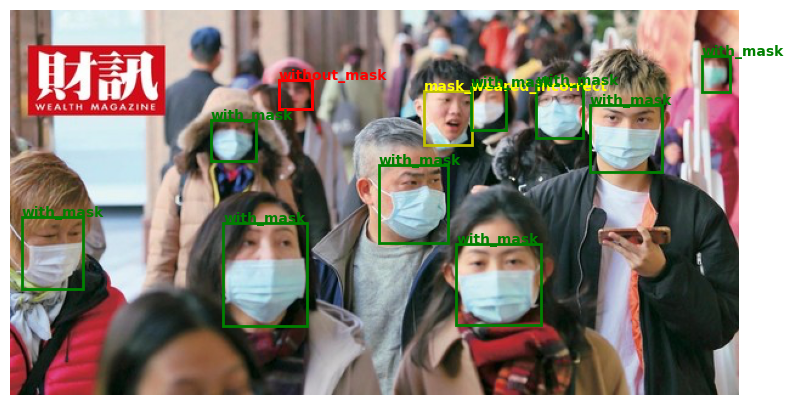

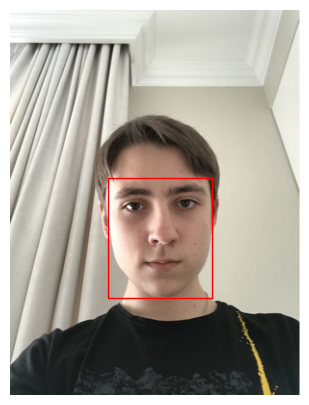

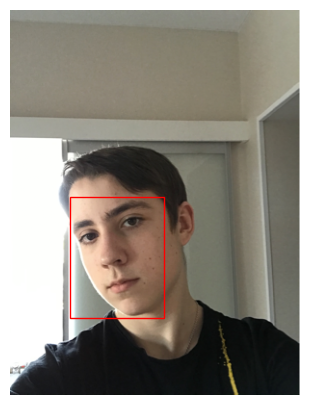

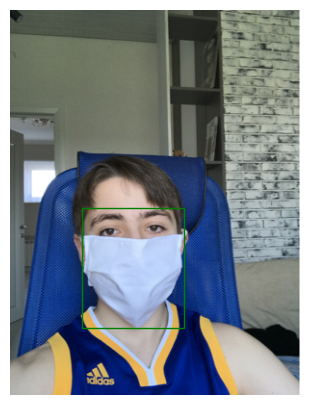

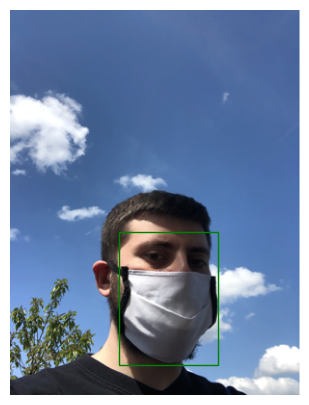

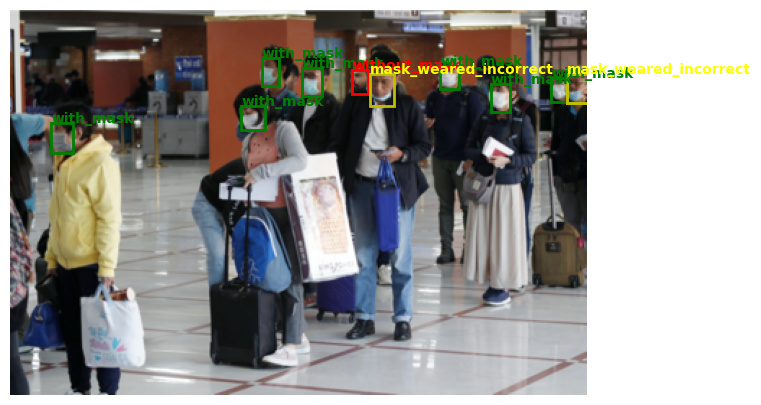

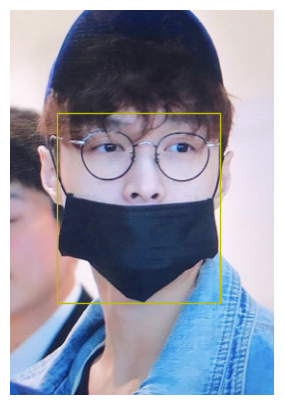

In [8]:
path_image="/Users/simranray/Desktop/fmd/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

dataset pre-processing

In [9]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}

In [10]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names_filtered)

train-test split

In [11]:
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


In [12]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

model

Resnet
ResNet is known for its ability to train very deep neural networks effectively, overcoming the vanishing gradient problem that occurs in traditional deep networks.

The key innovation of ResNet is the introduction of skip connections or residual connections. These connections allow the network to learn residual mappings, i.e., the difference between the input and output of a layer, instead of learning the complete transformation from the input to the output. By explicitly modeling the residual mappings, ResNet facilitates the training of deeper networks by making it easier for gradients to flow through the network during backpropagation.



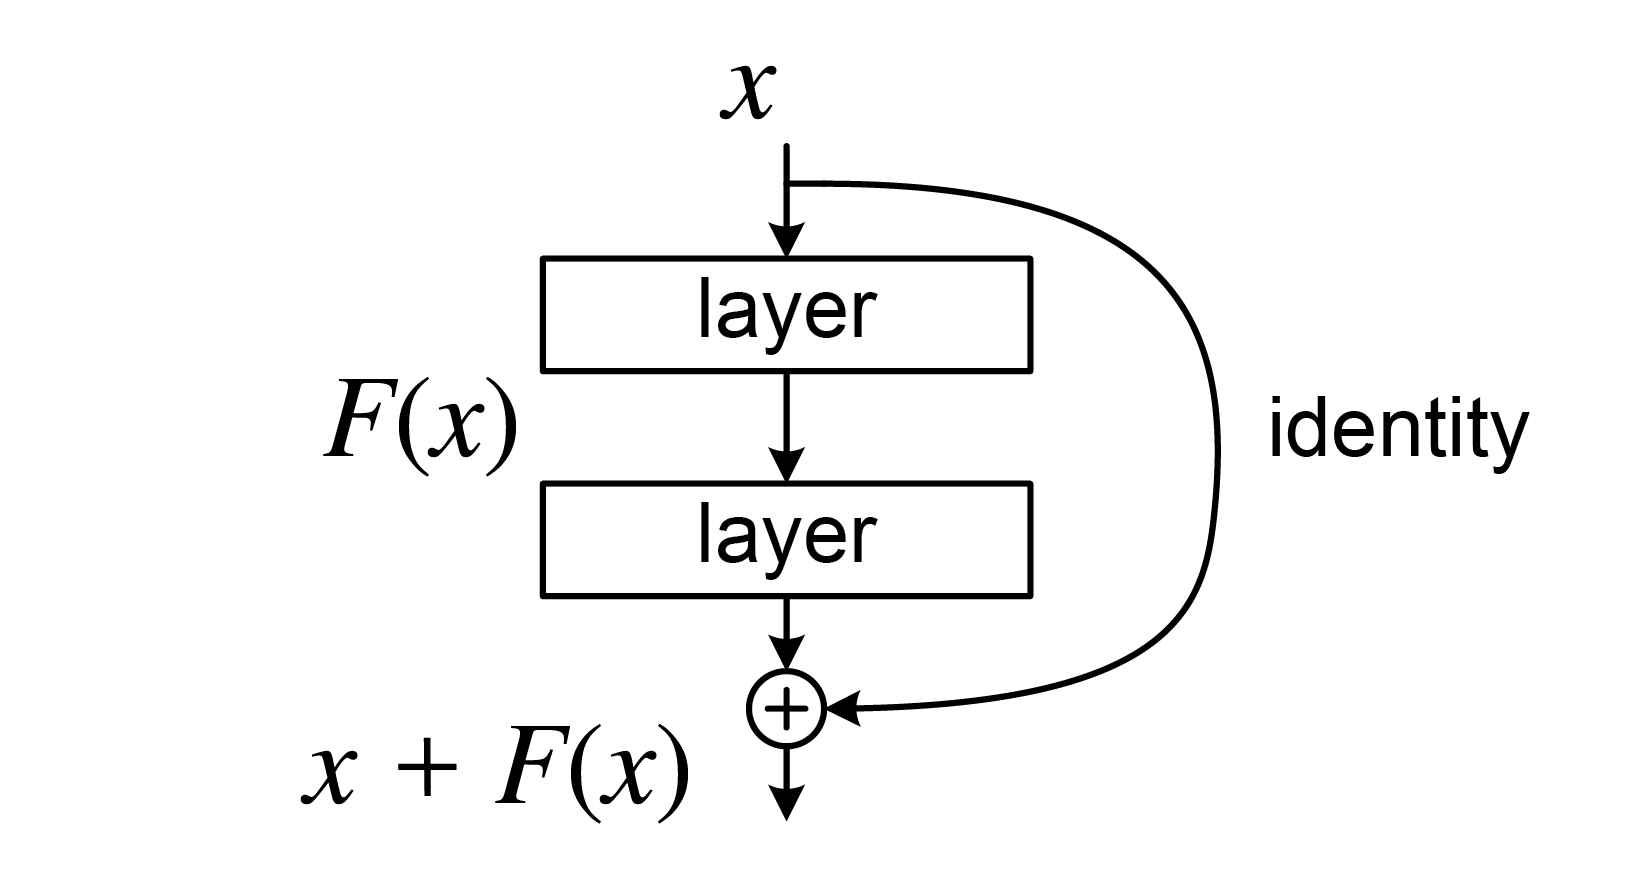

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models

# Define your model architecture
class MaskDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(MaskDetectionModel, self).__init__()
        # Load pre-trained ResNet-18 model
        self.resnet = models.resnet18(pretrained=True)
        # Replace the last fully connected layer with a new one
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
num_classes = 3  # Assuming you have three output classes
model = MaskDetectionModel(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Assuming you have trainset and testset from torch.utils.data.random_split
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(trainset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished!")

# Testing loop
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


/Users/simranray/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/simranray/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3456
Epoch [2/10], Loss: 0.1513
Epoch [3/10], Loss: 0.1159
Epoch [4/10], Loss: 0.0817
Epoch [5/10], Loss: 0.0544
Epoch [6/10], Loss: 0.0372
Epoch [7/10], Loss: 0.0289
Epoch [8/10], Loss: 0.0260
Epoch [9/10], Loss: 0.0185
Epoch [10/10], Loss: 0.0176
Training finished!
Test Accuracy: 0.9705
